In [1]:
import numpy as np
import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check asymptotics

In [2]:
d = 50
ns = 1000000
D_noise = np.random.uniform(0, 1, d)
E = np.random.multivariate_normal(np.zeros(D_noise.size), np.diag(D_noise), size=ns).T
Z = E - E.mean(axis=1, keepdims=True)
A = Z @ Z.T / (ns-1)

np.linalg.norm(A - np.diag(D_noise), 'fro') / np.linalg.norm(np.diag(D_noise), 'fro') , np.sqrt(d/ns)

(0.006317528382544317, 0.007071067811865475)

In [4]:
for K in [10, 20, 30, 50]:
    ns = 10**6
    true_D_noise = np.exp(np.random.randn(K))
    E = np.random.multivariate_normal(np.zeros(K), np.diag(true_D_noise[:K]), size=ns).T 
    E2 = np.diag(np.sqrt(true_D_noise[:K])) @ np.random.randn(K, ns)
    print(K, mf.rel_diff(np.diag(true_D_noise[:K]), (E @ E.T) / (ns - 1)), mf.rel_diff(np.diag(true_D_noise[:K]), (E2 @ E2.T) / (ns - 1)), np.sqrt(K / ns))

10 0.002112071766842613 0.002298285414544774 0.0031622776601683794
20 0.0033243775198434143 0.004314828866670062 0.00447213595499958
30 0.0031258518405309133 0.0035082903209570936 0.005477225575051661
50 0.004760510750993555 0.004208915676902205 0.007071067811865475


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mfmodel as mfm

plt.rcParams['text.usetex'] = True

# FactorAnalysis

In [74]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_diabetes

In [75]:
# data = load_iris()
# data = load_wine()
# data = load_breast_cancer()
data = load_diabetes()
data.data.shape

(442, 10)

In [90]:
n_factors = 3

## `sklearn.decomposition.FactorAnalysis`

In [91]:

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(data["data"])

X0 = mfm.standardize_matrix(data["data"], debug=True)
assert np.allclose(X, X0)

Sigma = X.T @ X / X.shape[0]
assert np.allclose(1, np.diag(Sigma))
assert np.allclose(0, X.sum(axis=0))


feature_names = data["feature_names"]

PCA [0.1 0.1 0.1]
Unrotated FA [0.27181476 0.22381484 0.07900778]
Varimax FA [0.2329281  0.19076863 0.15094065]


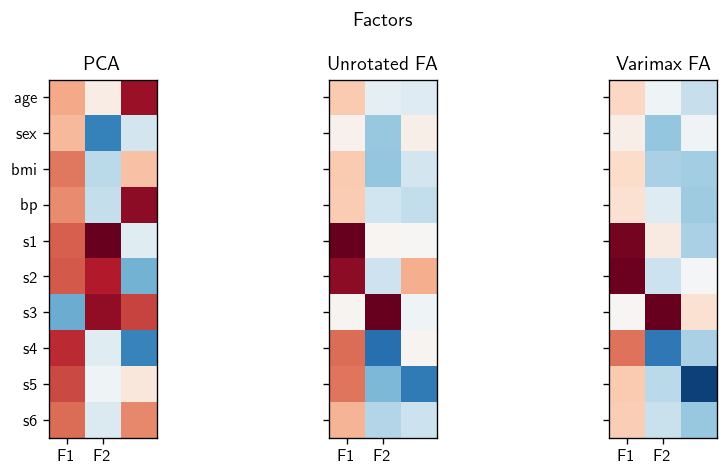

In [93]:
methods = [ ("PCA", PCA()),  ("Unrotated FA", FactorAnalysis()), ("Varimax FA", FactorAnalysis(rotation="varimax")),]
fig, axes = plt.subplots(ncols=len(methods), figsize=(8, 4), sharey=True, dpi=120)

for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_factors)
    fa.fit(X)
    components = fa.components_.T
    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names))); ax.set_yticklabels(feature_names)
    ax.set_title(str(method))
    ax.set_xticks([0, 1]); ax.set_xticklabels(["F1", "F2"])
    print(method, (components**2).sum(axis=0) / components.shape[0])
    if method == "Varimax FA":
        loadings1 = components
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

## `factor_analyzer.FactorAnalyzer`

In [94]:
data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [95]:
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer

df = pd.DataFrame(data.data, columns=data.feature_names)


fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')


fa.fit(df)
loadings = fa.loadings_
loadings2 = loadings
# print("Factor Loadings:\n", loadings)

print(f"{fa.get_communalities()=}")
print(f"{fa.get_uniquenesses()=}")

variance, prop_var, cum_var = fa.get_factor_variance()
print("\nFactor Variance (Eigenvalues):", variance)
print("Proportion of Variance Explained:", prop_var)
print("Cumulative Variance Explained:", cum_var)


fa.get_communalities()=array([0.21336595, 0.15322813, 0.3418804 , 0.47935317, 1.02343393,
       0.81927255, 0.98528641, 0.93007742, 0.51392438, 0.41431341])
fa.get_uniquenesses()=array([ 0.78663405,  0.84677187,  0.6581196 ,  0.52064683, -0.02343393,
        0.18072745,  0.01471359,  0.06992258,  0.48607562,  0.58568659])

Factor Variance (Eigenvalues): [2.16464388 1.95777909 1.75171278]
Proportion of Variance Explained: [0.21646439 0.19577791 0.17517128]
Cumulative Variance Explained: [0.21646439 0.4122423  0.58741358]


In [96]:
(loadings2**2).sum(axis=0) / loadings2.shape[0]

array([0.21646439, 0.19577791, 0.17517128])

## `mfmodel`

In [104]:
Y = mfm.standardize_matrix(data["data"], debug=True)
N, n = Y.shape
print(f"{N=}, {n=}")

L = 2
ranks = np.array([n_factors, 1])

pi_rows = np.arange(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

N=442, n=10
level=0, num_groups=1, mean_size=10.0
level=1, num_groups=10, mean_size=1.0


In [105]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(hpart)

num_levels=2, num_sparsities=1
(1, 1) [0]


In [116]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=2000, freq=100, init_type="Y", eps=1e-6)

t=0, obj=-14.034969229292962, np.percentile(D0, 1)=0.9694574948865876
t=100, obj=-10.515523989539526, np.percentile(D0, 1)=0.0024671480502891775
t=200, obj=-10.508102471636857, np.percentile(D0, 1)=0.0014341991274032218
t=300, obj=-10.505479651129967, np.percentile(D0, 1)=0.0010274071256373633
terminating at t=393
t=393, obj=-10.504213285408087, np.percentile(D1, 1)=0.0008163739483511504


In [117]:
F, D = fitted_mfm.F, fitted_mfm.D 

communalities = (F**2).sum(axis=1)
communalities.sum() / n, fitted_mfm.D.sum() / n

(0.5527576592105896, 0.42511598126886063)

In [118]:
variance = (F**2).sum(axis=0)
variance / n

array([0.34499078, 0.13315256, 0.07461432])

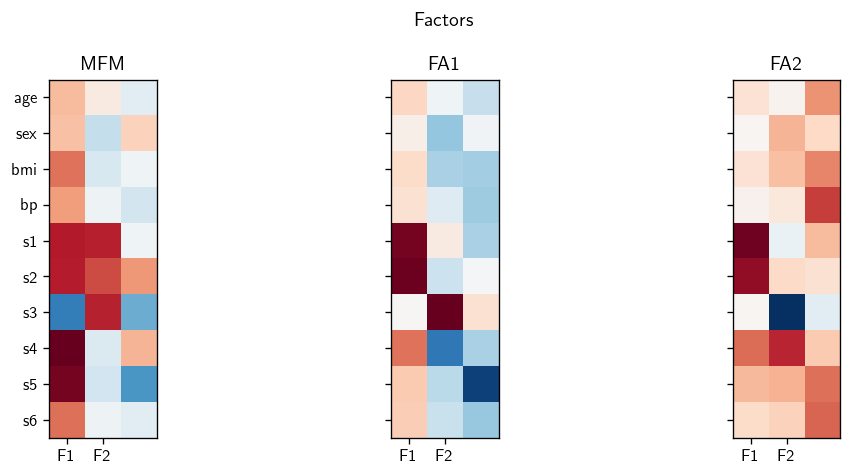

In [119]:
methods = [ ("MFM",fitted_mfm.F ),  ("FA1", loadings1),  ("FA2", loadings2)]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 4), sharey=True, dpi=120)

for ax, (method, F_load) in zip(axes, methods):
    vmax = np.abs(F_load).max()
    ax.imshow(F_load, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names))); ax.set_yticklabels(feature_names)
    ax.set_title(str(method))
    ax.set_xticks([0, 1]); ax.set_xticklabels(["F1", "F2"])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()